In [82]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [83]:
calib = np.load('../calib-from-video/phonecam_calib.npz')
K = calib['mtx']
dist = calib['dist']

In [84]:
imgl = cv.imread('./left.jpg')
imgl = cv.cvtColor(imgl, cv.COLOR_BGR2GRAY)

imgr = cv.imread('./right.jpg')
imgr = cv.cvtColor(imgr, cv.COLOR_BGR2GRAY)

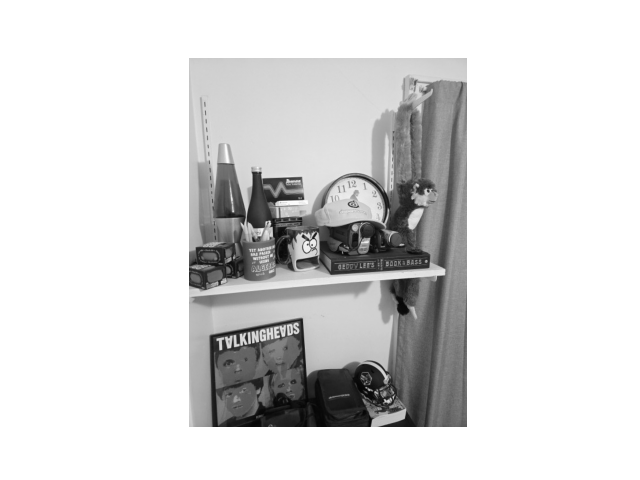

Clicked: (36, 478)
Clicked: (192, 450)
Clicked: (203, 322)
Clicked: (282, 254)
Clicked: (191, 206)
Clicked: (423, 235)
Clicked: (390, 450)
Clicked: (24, 367)
Clicked: (173, 474)


In [90]:
# %matplotlib widget
# import matplotlib.image as mpimg

# clicked_pts_l = []
# def onclick(event):
#     if event.inaxes:
#         x, y = int(event.xdata), int(event.ydata)
#         clicked_pts_l.append((x,y))
#         print(f"Clicked: ({x}, {y})")


# fig, ax = plt.subplots()
# ax.imshow(imgl, cmap='gray')
# ax.set_axis_off()
# cid = fig.canvas.mpl_connect('button_press_event', onclick)
# plt.show()

clicked_pts_l = [(36, 478),
 (192, 450),
 (203, 322),
 (282, 254),
 (191, 206),
 (423, 235),
 (390, 450),
 (24, 367),
 (173, 474)]


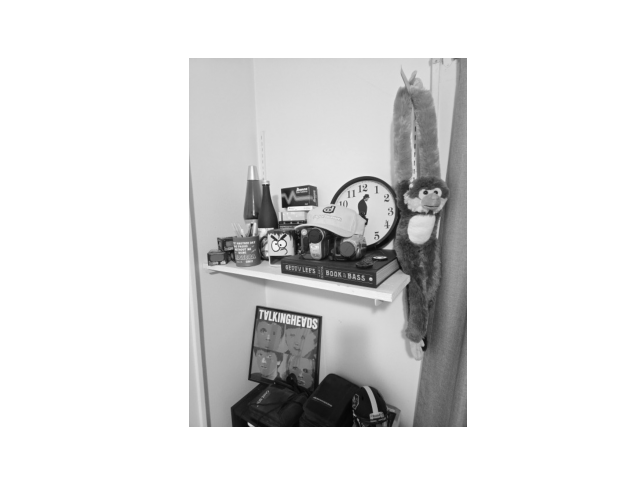

Clicked: (118, 426)
Clicked: (225, 448)
Clicked: (149, 318)
Clicked: (237, 263)
Clicked: (203, 218)
Clicked: (419, 239)
Clicked: (384, 517)
Clicked: (29, 336)
Clicked: (206, 462)


In [91]:
# %matplotlib widget
# import matplotlib.image as mpimg

# clicked_pts_r = []
# def onclick(event):
#     if event.inaxes:
#         x, y = int(event.xdata), int(event.ydata)
#         clicked_pts_r.append((x,y))
#         print(f"Clicked: ({x}, {y})")


# fig, ax = plt.subplots()
# ax.imshow(imgr, cmap='gray')
# ax.set_axis_off()
# cid = fig.canvas.mpl_connect('button_press_event', onclick)
# plt.show()

clicked_pts_r = [[(118, 426),
 (225, 448),
 (149, 318),
 (237, 263),
 (203, 218),
 (419, 239),
 (384, 517),
 (29, 336),
 (206, 462)]]


In [92]:
assert len(clicked_pts_l) == len(clicked_pts_r)

In [93]:
F, mask = cv.findFundamentalMat(
    points1=np.array(clicked_pts_l),
    points2=np.array(clicked_pts_r),
    method=cv.RANSAC
)

In [94]:
F

array([[ 1.62431699e-06,  8.85876100e-06, -3.62952236e-03],
       [-1.21788739e-06,  3.66568740e-06, -4.81185378e-03],
       [ 7.59966244e-04,  4.52815557e-04,  1.00000000e+00]])

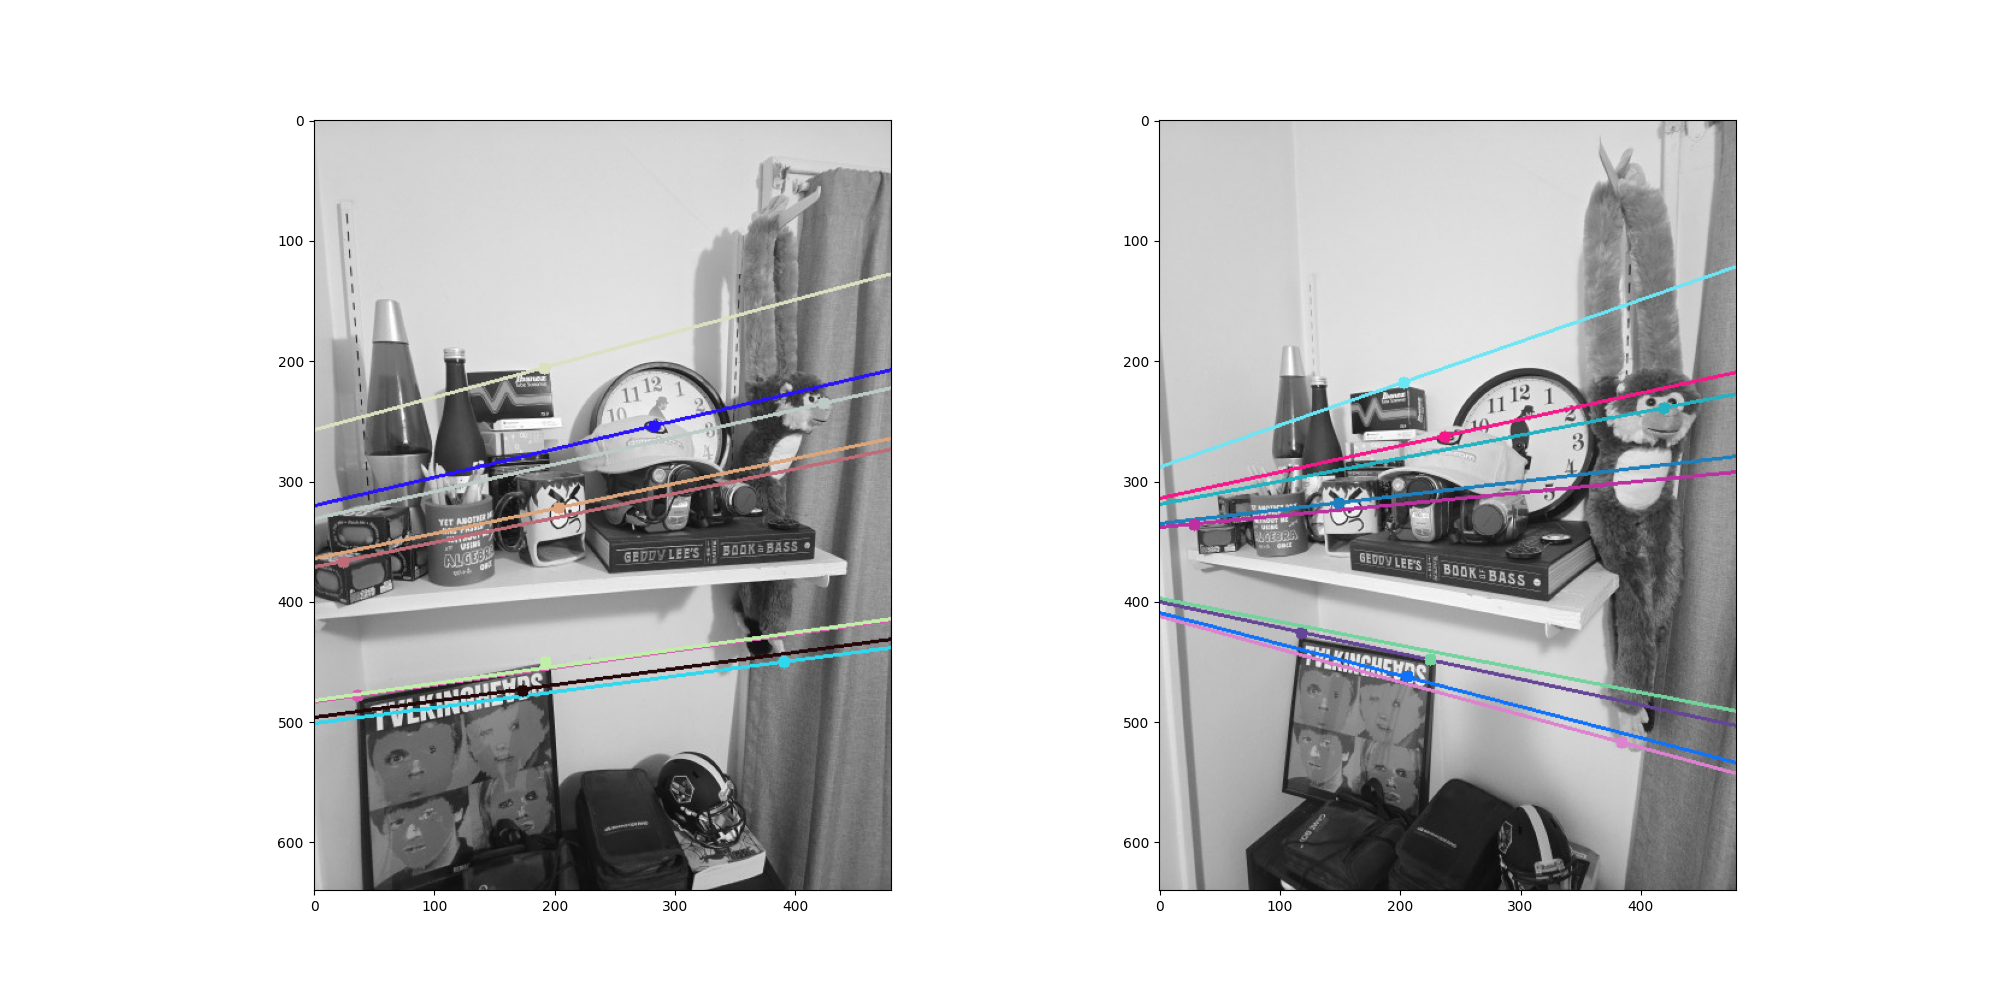

In [95]:
# Draw epilines on second image
def drawlines(img1, img2, lines, pts1, pts2):
    """
    img1 - image on which we draw epilines from points in img2
    """
    r, c = img1.shape
    
    # Back to color
    img1 = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2, cv.COLOR_GRAY2BGR)

    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])

        img1 = cv.line(img1, (x0, y0), (x1, y1), color, 2)
        img1 = cv.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

l1 = cv.computeCorrespondEpilines(np.array(clicked_pts_r), 2, F)
l1 = l1.reshape(-1, 3)
img5, img6 = drawlines(imgl, imgr, l1, np.array(clicked_pts_l), np.array(clicked_pts_r))
l2 = cv.computeCorrespondEpilines(np.array(clicked_pts_l), 1, F)
l2 = l2.reshape(-1, 3)
img7, img8 = drawlines(imgr, imgl, l2, np.array(clicked_pts_r), np.array(clicked_pts_l))

fig = plt.figure(figsize=(20,10))
fig.add_subplot(121)
plt.imshow(img5)
fig.add_subplot(122)
plt.imshow(img7)

# Get the essential matrix

Should also just be able to do this algebraically

In [96]:
E, mask = cv.findEssentialMat(
    points1=np.array(clicked_pts_l),
    points2=np.array(clicked_pts_r),
    cameraMatrix=K,
    method=cv.RANSAC,
)
E

array([[ 0.00237932,  0.28041416,  0.03739286],
       [ 0.28495652,  0.00938513, -0.64627851],
       [ 0.03811453,  0.64760939,  0.01221306]])

## Recover the pose

In [97]:
_, E_ref, R, T, mask = cv.recoverPose(
    points1=np.array(clicked_pts_l, dtype=np.float32),
    points2=np.array(clicked_pts_r, dtype=np.float32),
    cameraMatrix1=K,
    cameraMatrix2=K,
    distCoeffs1=dist,
    distCoeffs2=dist,
    E=E
)

In [98]:
print(R)
print(T)

[[ 0.64083254 -0.09607737  0.7616448 ]
 [ 0.09516178  0.99442717  0.0453744 ]
 [-0.76175973  0.04340208  0.64640418]]
[[-0.91293479]
 [-0.03023753]
 [ 0.40698373]]


# Triangulate

We have 
* Intrinsics $K$
* relative pose $R$ and $t$ (directional only)
* matched image points

We do not have scale!

In [99]:
P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
P2 = K @ np.hstack((R, T))

pts1 = np.asarray(clicked_pts_l, dtype=np.float64).T
pts2 = np.asarray(clicked_pts_r, dtype=np.float64).T

X_h = cv.triangulatePoints(P1, P2, pts1, pts2)
X_h.shape

(4, 9)

Output is in homogeneous coordinates, so we need to normalize to get to R3

In [100]:
X = X_h[:3] / X_h[3]

In [101]:
X

array([[-0.51069955, -0.1424777 , -0.08387632,  0.09586114, -0.1269253 ,
         0.47306307,  0.4125568 , -0.37671978, -0.1928608 ],
       [ 0.41603086,  0.3980434 ,  0.0156244 , -0.13886821, -0.26405514,
        -0.19982844,  0.37359152,  0.09553565,  0.45552621],
       [ 1.12910977,  1.30212231,  0.97525062,  1.08601773,  1.13455995,
         1.18739087,  1.2779696 ,  0.78615678,  1.2737518 ]])

In [107]:
# Do reprojection for debugging
def project(P, X):
    Xh = np.vstack((X, np.ones(X.shape[1])))
    x = P @ Xh
    return x[:2] / x[2]

pts1_proj = project(P1, X)
pts2_proj = project(P2, X)

err1 = np.linalg.norm(pts1_proj - pts1[:], axis=0)
err2 = np.linalg.norm(pts2_proj - pts2[:], axis=0)

print(f"Mean reprojection errors: {err1.mean():.2f}, {err2.mean():.2f}")

Mean reprojection errors: 1.24, 1.42


In [105]:
err1, err2

(array([1.02296187, 0.51989989, 2.98479479, 0.2880702 , 0.11115212,
        0.36370022, 5.71961974, 0.08743323, 0.08488402]),
 array([0.74243504, 0.488836  , 2.64109236, 0.30437269, 0.10329659,
        0.53779017, 7.81178196, 0.05689151, 0.07677226]))

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_camera(ax, K, R, t, scale=0.1, color='r'):
    """
    Plot a simple camera frustum.
    
    Args:
        ax : matplotlib 3d axis
        K  : camera intrinsic matrix (3x3)
        R  : rotation matrix (3x3)
        t  : translation vector (3x1)
        scale : size of frustum lines
        color : frustum color
    """
    # Camera center
    C = -R.T @ t
    C = C.ravel()   # flatten to 1D

    # Camera axes in world coordinates
    x_axis = R.T @ np.array([1,0,0])
    y_axis = R.T @ np.array([0,1,0])
    z_axis = R.T @ np.array([0,0,1])

    # Plot camera center
    ax.scatter(C[0], C[1], C[2], c=color, marker='o')

    # Draw axes
    ax.quiver(C[0], C[1], C[2], x_axis[0], x_axis[1], x_axis[2], length=scale, color='r')
    ax.quiver(C[0], C[1], C[2], y_axis[0], y_axis[1], y_axis[2], length=scale, color='g')
    ax.quiver(C[0], C[1], C[2], z_axis[0], z_axis[1], z_axis[2], length=scale, color='b')

    # Frustum corners in camera coords (assumes normalized image plane at z=1)
    h, w = 2 * K[1,2] / K[1,1], 2 * K[0,2] / K[0,0]  # approx height and width in normalized units
    corners_cam = np.array([
        [ w/2,  h/2, 1],
        [ w/2, -h/2, 1],
        [-w/2, -h/2, 1],
        [-w/2,  h/2, 1]
    ]).T

    # Transform corners to world coords
    corners_world = R.T @ corners_cam + C.reshape(3,1)

    # Draw frustum edges
    for i in range(4):
        ax.plot([C[0], float(corners_world[0,i])],
                [C[1], float(corners_world[1,i])],
                [C[2], float(corners_world[2,i])],
                color=color)

    # Connect corners
    corners_world = np.hstack((corners_world, corners_world[:,0:1]))  # close the loop
    ax.plot(corners_world[0], corners_world[1], corners_world[2], color=color)

def plot_scene(K, R, t, X):
    """
    Plot cameras and 3D points.
    
    Args:
        K : intrinsic matrix
        R, t : pose of camera 2 relative to camera 1
        X : 3D points in camera 1 frame (3xN)
    """
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot camera 1 (identity pose)
    plot_camera(ax, K, np.eye(3), np.zeros((3,1)), scale=0.2, color='r')

    # Plot camera 2 (R,t)
    plot_camera(ax, K, R, t, scale=0.2, color='b')

    # Plot 3D points
    ax.scatter(X[0], X[1], X[2], s=15, c='k')

    # Set labels and equal aspect
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1,1,1])

    # Set limits based on points and cameras
    all_points = np.hstack((X, -R.T @ t.reshape(3,1)))  # points + cam2 center
    mins = all_points.min(axis=1)
    maxs = all_points.max(axis=1)
    ax.set_xlim(mins[0], maxs[0])
    ax.set_ylim(mins[1], maxs[1])
    ax.set_zlim(mins[2], maxs[2])

    plt.show()


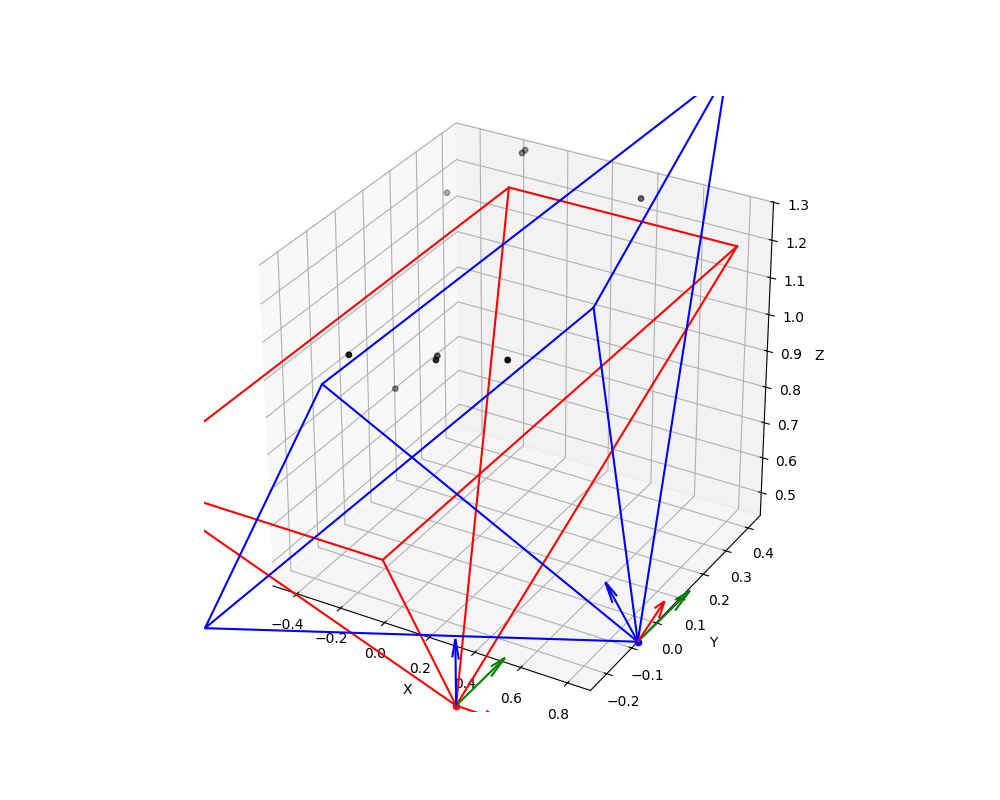

In [122]:
plot_scene(K, R, T, X)

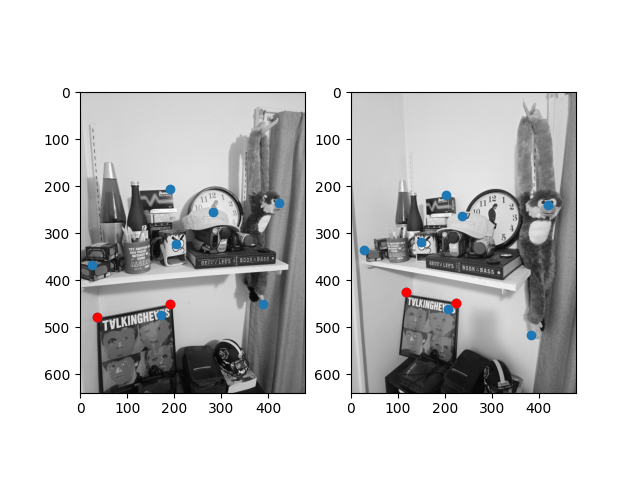

In [126]:
fig, ax = plt.subplots(ncols=2)
cpl = np.array(clicked_pts_l)
cpr = np.array(clicked_pts_r)
ax[0].imshow(imgl, cmap='gray')
ax[0].scatter(cpl[:,0], cpl[:,1])
ax[0].scatter(cpl[:2,0], cpl[:2,1], color='red')
ax[1].imshow(imgr, cmap='gray')
ax[1].scatter(cpr[:,0], cpr[:,1])
ax[1].scatter(cpr[:2,0], cpr[:2,1], color='red')

I measured the distance between the two red points to be 32 cm. The points returned by the triangulation are scaled arbitrarily. So I can calculate the current distance between these two red points, and divide 32 cm by this distance to get a scaling factor that I can then apply to _all 3D points_ in order to get actual distances on my 3D points.

In [131]:
dist_actual = 0.32  # 32 cm
p1, p2 = X[:, 0], X[:, 1]
dist_arb = np.linalg.norm(p2 - p1)

scale_factor = dist_actual / dist_arb
scale_factor

# Apply this scale factor to the relevant quantities
X_scaled = X * scale_factor
T_scaled = T * scale_factor

In [135]:
np.linalg.norm(X_scaled[:,0] - X_scaled[:,1])

np.float64(0.31999999999999995)

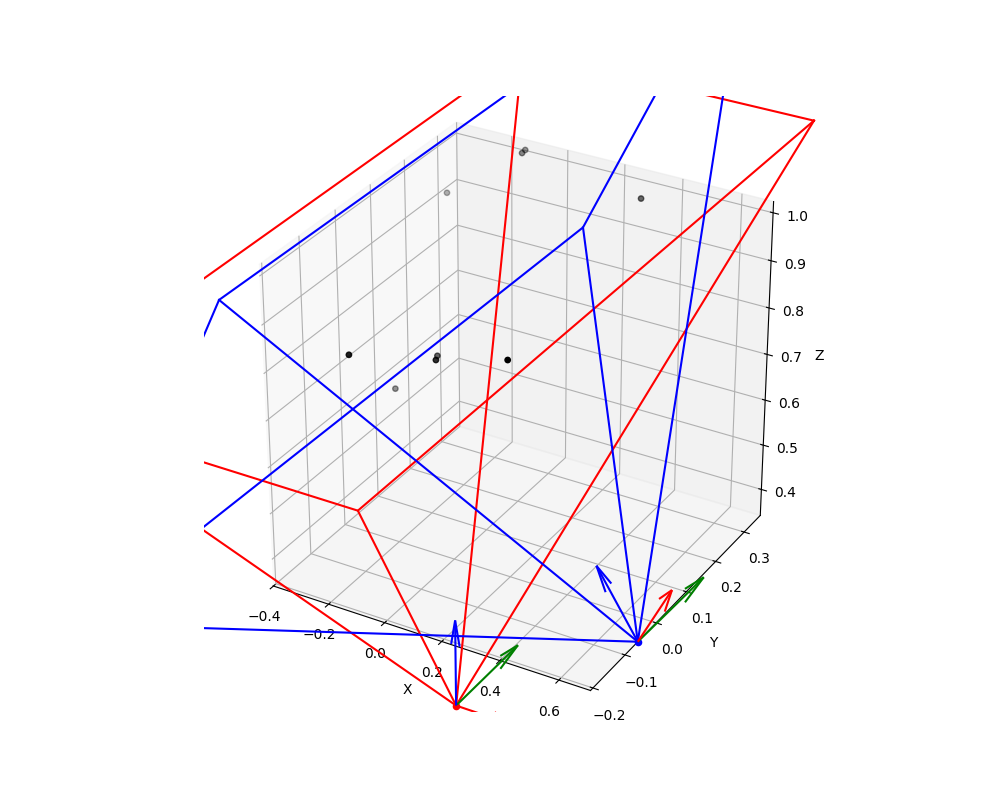

In [137]:
plot_scene(K, R, T_scaled, X_scaled)

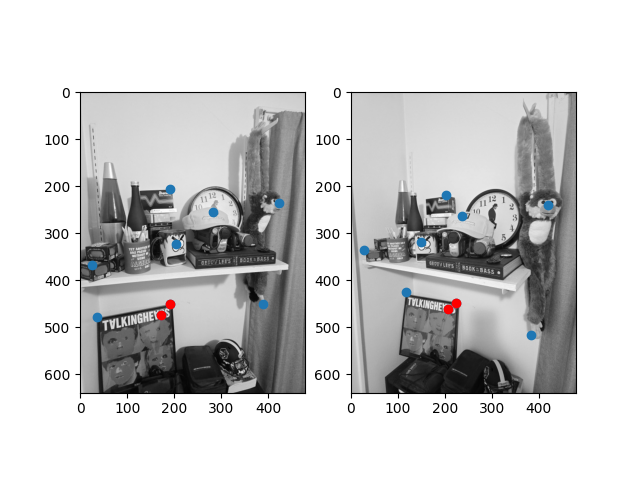

In [141]:
fig, ax = plt.subplots(ncols=2)
cpl = np.array(clicked_pts_l)
cpr = np.array(clicked_pts_r)
ax[0].imshow(imgl, cmap='gray')
ax[0].scatter(cpl[:,0], cpl[:,1])
ax[0].scatter(cpl[1,0], cpl[1,1], color='red')
ax[0].scatter(cpl[8,0], cpl[8,1], color='red')
ax[1].imshow(imgr, cmap='gray')
ax[1].scatter(cpr[:,0], cpr[:,1])
ax[1].scatter(cpr[1,0], cpr[1,1], color='red')
ax[1].scatter(cpr[8,0], cpr[8,1], color='red')

I measured this distance at a little over 6 cm. Let's check the numbers...

In [146]:
res = np.linalg.norm(X_scaled[:, 1] - X_scaled[:,8])
print(f"Measured to be {100*res:.2f} cm")

Measured to be 6.41 cm


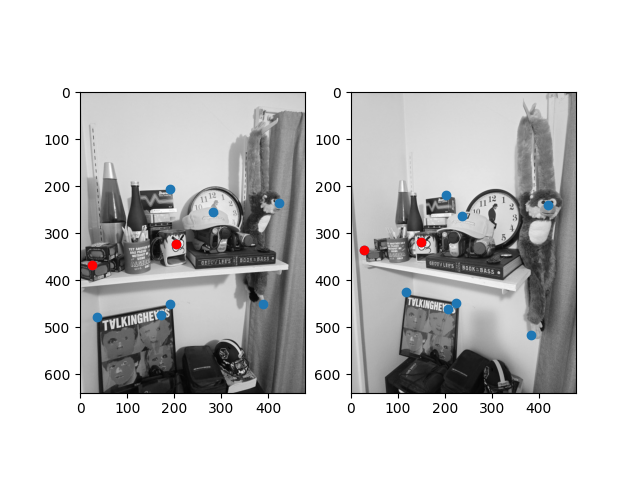

In [156]:
fig, ax = plt.subplots(ncols=2)
cpl = np.array(clicked_pts_l)
cpr = np.array(clicked_pts_r)
ax[0].imshow(imgl, cmap='gray')
ax[0].scatter(cpl[:,0], cpl[:,1])
ax[0].scatter(cpl[2,0], cpl[2,1], color='red')
ax[0].scatter(cpl[7,0], cpl[7,1], color='red')
ax[1].imshow(imgr, cmap='gray')
ax[1].scatter(cpr[:,0], cpr[:,1])
ax[1].scatter(cpr[2,0], cpr[2,1], color='red')
ax[1].scatter(cpr[7,0], cpr[7,1], color='red')

I measured this distance to be about 26 cm.

In [157]:
res = np.linalg.norm(X_scaled[:, 2] - X_scaled[:, 7])
print(f"Measured to be {100*res:.2f} cm")

Measured to be 28.10 cm


Now that we have the scaled distances --- including the scaled pose translation $T_{\text{scaled}}$ --- we can take new point correspondences in our images, and triangulate to get their actual, real-world distances!

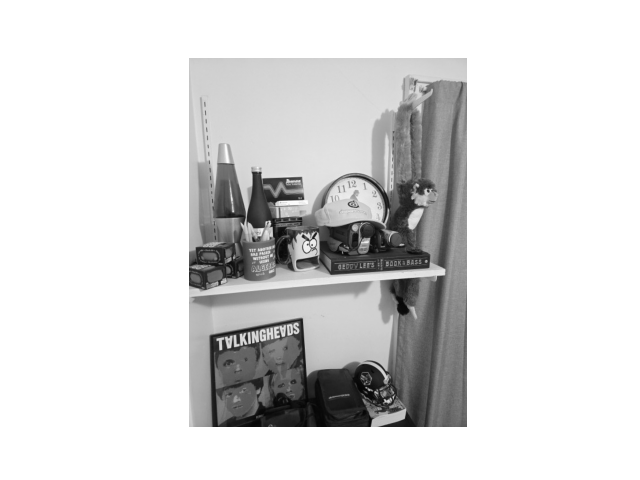

Clicked: (242, 374)
Clicked: (244, 351)


In [167]:
%matplotlib widget
import matplotlib.image as mpimg

new_pts_l = []
def onclick(event):
    if event.inaxes:
        x, y = int(event.xdata), int(event.ydata)
        new_pts_l.append((x,y))
        print(f"Clicked: ({x}, {y})")


fig, ax = plt.subplots()
ax.imshow(imgl, cmap='gray')
ax.set_axis_off()
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()


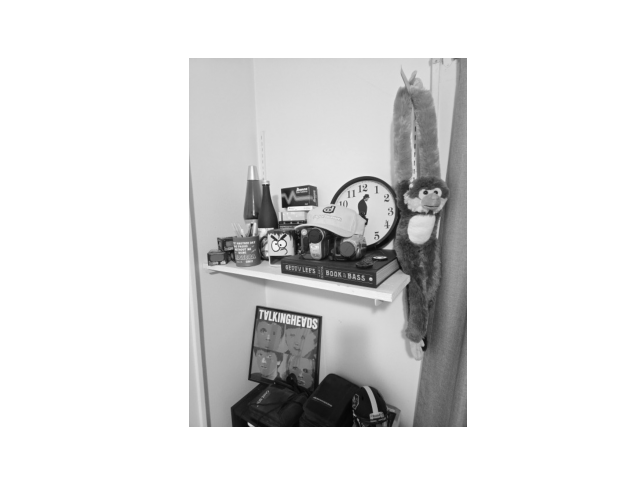

Clicked: (156, 370)
Clicked: (156, 348)


In [168]:
new_pts_r = []
def onclick(event):
    if event.inaxes:
        x, y = int(event.xdata), int(event.ydata)
        new_pts_r.append((x,y))
        print(f"Clicked: ({x}, {y})")



fig, ax = plt.subplots()
ax.imshow(imgr, cmap='gray')
ax.set_axis_off()
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [169]:
P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
P2 = K @ np.hstack((R, T_scaled))   # Here we use T_scaled instead of T (which had arbitrary scale)

pts1 = np.asarray(new_pts_l, dtype=np.float64).T
pts2 = np.asarray(new_pts_r, dtype=np.float64).T

X_h = cv.triangulatePoints(P1, P2, pts1, pts2)

X_new = X_h[:3] / X_h[3]

In [171]:
dist_new = np.linalg.norm(X_new[:,0] - X_new[:, 1])
print(f"Distance: {dist_new*100:0.2f} cm.")

Distance: 4.00 cm.


In [172]:
dist_new

np.float64(0.03998839650145175)